# Predictive Modeling: IMDB Movie Rating Analysis

**Author:** Data Mining Project  
**Dataset:** IMDB Movies Processed Dataset  
**Objective:** Build end-to-end predictive models for movie rating prediction (regression) and hit classification

---

## Project Overview

This notebook implements comprehensive machine learning models to:
1. **Regression:** Predict `averageRating` using movie features
2. **Classification:** Predict whether a movie is a "hit" (rating ≥ 7.0)

**Key Sections:**
- Data loading & preprocessing
- Feature engineering
- Multiple regression models (Linear, RF)
- Classification models (Logistic, RF)
- Cross-validation & hyperparameter tuning
- Feature importance analysis
- Genre-stratified modeling
- Residual analysis & model comparison

## 1. Setup & Library Imports

Import all required libraries for data manipulation, modeling, and visualization.

In [156]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# Utilities
from time import time

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Data Loading

Load the processed IMDB dataset and perform initial exploration.

In [157]:
# Load dataset
df = pd.read_csv('../data/processed/imdb_movies_processed.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print("\n" + "="*60)

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (336000, 32)
Rows: 336,000 | Columns: 32


First 5 rows:


,tconst,primaryTitle,originalTitle,titleType,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,decade,primaryGenre,numGenres,logVotes,bayes_rating,runtime_bin,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Other,genre_Romance,genre_Thriller,genre_Unknown
0,tt0000009,Miss Jerry,Miss Jerry,movie,0,1894.0,45.0,Romance,5.2,231.0,1890,Romance,1,5.446737,5.771578,Short (<60),False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,movie,0,1897.0,100.0,"Documentary,News,Sport",5.3,578.0,1890,Documentary,3,6.361302,5.615944,Standard (90-120),False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,tt0000335,Soldiers of the Cross,Soldiers of the Cross,movie,0,1900.0,40.0,"Biography,Drama",5.5,64.0,1900,Biography,2,4.174387,6.066317,Short (<60),False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,tt0000502,Bohemios,Bohemios,movie,0,1905.0,100.0,Unknown,3.1,25.0,1900,Unknown,0,3.258097,5.957993,Standard (90-120),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,movie,0,1906.0,70.0,"Action,Adventure,Biography",6.0,1039.0,1900,Action,3,6.946976,6.042373,Medium (60-90),True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [158]:
# Dataset information
print("Column Data Types:")
print(df.dtypes)
print("\n" + "="*60)

print("\nMissing Values Summary:")
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

Column Data Types:
tconst                object
primaryTitle          object
originalTitle         object
titleType             object
isAdult                int64
startYear            float64
runtimeMinutes       float64
genres                object
averageRating        float64
numVotes             float64
decade                 int64
primaryGenre          object
numGenres              int64
logVotes             float64
bayes_rating         float64
runtime_bin           object
genre_Action            bool
genre_Adult             bool
genre_Adventure         bool
genre_Animation         bool
genre_Biography         bool
genre_Comedy            bool
genre_Crime             bool
genre_Documentary       bool
genre_Drama             bool
genre_Family            bool
genre_Fantasy           bool
genre_Horror            bool
genre_Other             bool
genre_Romance           bool
genre_Thriller          bool
genre_Unknown           bool
dtype: object


Missing Values Summary:
Empty DataFra

In [159]:
# Statistical summary
print("Statistical Summary of Key Numeric Columns:")
df[['averageRating', 'numVotes', 'runtimeMinutes']].describe()

Statistical Summary of Key Numeric Columns:


,averageRating,numVotes,runtimeMinutes
count,336000.000000,336000.000000,336000.000000
mean,6.177838,2489.700136,94.296202
std,1.383202,14532.818726,168.119508
min,1.000000,5.000000,1.000000
25%,5.300000,20.000000,82.000000
50%,6.300000,64.000000,91.000000
75%,7.100000,325.000000,101.000000
max,10.000000,159752.145000,59460.000000


## 3. Data Cleaning & Feature Engineering

Prepare the dataset for modeling:
- Drop non-predictive identifiers
- Encode categorical variables
- Create classification target (hit label)
- Handle missing values
- Engineer features

In [160]:
# Create a copy for processing
df_model = df.copy()[:10000]  # Limit to first 10,000 rows for efficiency   

# Check available columns
print("Available columns:")
print(df_model.columns.tolist())
print("\n" + "="*60)

Available columns:
['tconst', 'primaryTitle', 'originalTitle', 'titleType', 'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'decade', 'primaryGenre', 'numGenres', 'logVotes', 'bayes_rating', 'runtime_bin', 'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Thriller', 'genre_Unknown']



In [161]:
# Step 1: Drop non-predictive identifiers
columns_to_drop = ['tconst']

# Check if 'titles' column exists (might be named differently)
if 'titles' in df_model.columns:
    columns_to_drop.append('titles')
elif 'primaryTitle' in df_model.columns:
    columns_to_drop.append('primaryTitle')
elif 'title' in df_model.columns:
    columns_to_drop.append('title')

print(f"Dropping columns: {columns_to_drop}")
df_model = df_model.drop(columns=[col for col in columns_to_drop if col in df_model.columns], errors='ignore')

print(f"Dataset shape after dropping identifiers: {df_model.shape}")

Dropping columns: ['tconst', 'primaryTitle']
Dataset shape after dropping identifiers: (10000, 30)


In [162]:
# Step 2: Create classification target - 'hit' label
# hit = 1 if averageRating >= 7.0, else 0
df_model['hit'] = (df_model['averageRating'] >= 7.0).astype(int)

print("Classification target distribution:")
print(df_model['hit'].value_counts())
print(f"\nHit rate: {100 * df_model['hit'].mean():.2f}%")

Classification target distribution:
hit
0    8508
1    1492
Name: count, dtype: int64

Hit rate: 14.92%


In [163]:
# Step 3: Handle missing values in key numeric columns
# Impute runtimeMinutes with median
if 'runtimeMinutes' in df_model.columns:
    if df_model['runtimeMinutes'].isnull().sum() > 0:
        median_runtime = df_model['runtimeMinutes'].median()
        df_model['runtimeMinutes'].fillna(median_runtime, inplace=True)
        print(f"✓ Imputed runtimeMinutes with median: {median_runtime}")

# Ensure logVotes exists and is numeric
if 'logVotes' in df_model.columns:
    df_model['logVotes'] = pd.to_numeric(df_model['logVotes'], errors='coerce')
    if df_model['logVotes'].isnull().sum() > 0:
        df_model['logVotes'].fillna(df_model['logVotes'].median(), inplace=True)
        print(f"✓ Imputed logVotes")
elif 'numVotes' in df_model.columns:
    # Create logVotes if it doesn't exist
    df_model['logVotes'] = np.log1p(df_model['numVotes'])
    print("✓ Created logVotes from numVotes")

print("\nMissing values after imputation:")
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])


Missing values after imputation:
Series([], dtype: int64)


In [164]:
# Step 4: Encode categorical variables

# Encode director using LabelEncoder
if 'director' in df_model.columns:
    le_director = LabelEncoder()
    # Handle missing directors
    df_model['director'].fillna('Unknown', inplace=True)
    df_model['director_encoded'] = le_director.fit_transform(df_model['director'].astype(str))
    print(f"✓ Encoded director: {df_model['director_encoded'].nunique()} unique directors")
    # Keep original for later analysis
else:
    print("⚠ director column not found")

# Ensure decade is numeric
if 'decade' in df_model.columns:
    df_model['decade'] = pd.to_numeric(df_model['decade'], errors='coerce')
    df_model['decade'].fillna(df_model['decade'].median(), inplace=True)
    print(f"✓ Decade is numeric")

# Handle primaryGenre - one-hot encode if needed
if 'primaryGenre' in df_model.columns:
    # Check if genre_* columns already exist
    genre_cols = [col for col in df_model.columns if col.startswith('genre_')]
    if len(genre_cols) == 0:
        # Create one-hot encoding
        genre_dummies = pd.get_dummies(df_model['primaryGenre'], prefix='genre')
        df_model = pd.concat([df_model, genre_dummies], axis=1)
        print(f"✓ Created {len(genre_dummies.columns)} genre one-hot columns")
    else:
        print(f"✓ Using existing {len(genre_cols)} genre columns")

# Handle runtime_bin - one-hot encode if needed
if 'runtime_bin' in df_model.columns:
    runtime_bin_cols = [col for col in df_model.columns if col.startswith('runtime_bin_')]
    if len(runtime_bin_cols) == 0:
        runtime_dummies = pd.get_dummies(df_model['runtime_bin'], prefix='runtime_bin')
        df_model = pd.concat([df_model, runtime_dummies], axis=1)
        print(f"✓ Created {len(runtime_dummies.columns)} runtime_bin one-hot columns")
    else:
        print(f"✓ Using existing {len(runtime_bin_cols)} runtime_bin columns")

print(f"\nFinal dataset shape: {df_model.shape}")

⚠ director column not found
✓ Decade is numeric
✓ Using existing 16 genre columns
✓ Created 5 runtime_bin one-hot columns

Final dataset shape: (10000, 36)


In [165]:
# Step 5: Prepare feature matrix X and target variables

# Define target variables
y_reg = df_model['averageRating'].copy()
y_cls = df_model['hit'].copy()

# Select feature columns (exclude targets and original categorical columns)
exclude_cols = ['averageRating', 'hit', 'director', 'primaryGenre', 'runtime_bin']

# Get all feature columns
feature_cols = [col for col in df_model.columns if col not in exclude_cols]

# Remove any remaining non-numeric columns
X = df_model[feature_cols].copy()

# Convert all to numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop columns with all NaN
X = X.dropna(axis=1, how='all')

# Replace infinities with NaN, then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Ensure all values are float64
X = X.astype('float64')
clean_X = X.copy()
clean_X.columns = (
    clean_X.columns
    .str.replace('[', '_', regex=False)
    .str.replace(']', '_', regex=False)
    .str.replace('<', '_', regex=False)
    .str.replace('>', '_', regex=False)
    .str.replace(',', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

X = clean_X
print(f"✓ Feature matrix prepared successfully")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Regression target shape: {y_reg.shape}")
print(f"Classification target shape: {y_cls.shape}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"\nFeature columns:")
print(X.columns.tolist())

✓ Feature matrix prepared successfully

Feature matrix shape: (10000, 30)
Regression target shape: (10000,)
Classification target shape: (10000,)

Number of features: 30

Feature columns:
['originalTitle', 'isAdult', 'startYear', 'runtimeMinutes', 'numVotes', 'decade', 'numGenres', 'logVotes', 'bayes_rating', 'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Other', 'genre_Romance', 'genre_Thriller', 'genre_Unknown', 'runtime_bin_Long_(120-150)', 'runtime_bin_Medium_(60-90)', 'runtime_bin_Short_(_60)', 'runtime_bin_Standard_(90-120)', 'runtime_bin_Very_Long_(_150)']


## 4. Train/Test Split

Split data into training (80%) and testing (20%) sets with stratification for classification target.

In [166]:
# Perform stratified train-test split (80/20)
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X, y_reg, y_cls, 
    test_size=0.2, 
    random_state=42,
    stratify=y_cls  # Stratify based on classification target
)

print("Train/Test Split Results:")
print("=" * 60)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"\nRegression targets:")
print(f"  y_reg_train: {y_reg_train.shape}")
print(f"  y_reg_test:  {y_reg_test.shape}")
print(f"\nClassification targets:")
print(f"  y_cls_train: {y_cls_train.shape}")
print(f"  y_cls_test:  {y_cls_test.shape}")

print(f"\nTraining set hit rate: {100 * y_cls_train.mean():.2f}%")
print(f"Test set hit rate:     {100 * y_cls_test.mean():.2f}%")

Train/Test Split Results:
X_train shape: (8000, 30)
X_test shape:  (2000, 30)

Regression targets:
  y_reg_train: (8000,)
  y_reg_test:  (2000,)

Classification targets:
  y_cls_train: (8000,)
  y_cls_test:  (2000,)

Training set hit rate: 14.92%
Test set hit rate:     14.90%


In [167]:
# Standardize features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features standardized for linear/logistic models")

✓ Features standardized for linear/logistic models


## 5. Regression Models: Predict Average Rating

Build and evaluate three regression models to predict `averageRating`:
1. **Linear Regression** - Baseline linear model
2. **Random Forest Regressor** - Ensemble tree-based model

**Evaluation Metrics:**
- **R² Score:** Proportion of variance explained (higher is better)
- **RMSE:** Root Mean Squared Error (lower is better)
- **MAE:** Mean Absolute Error (lower is better)

In [ ]:


# ---------- Standardize features (for linear models) ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert back to DataFrame for readability / plotting later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

print("✓ Features standardized for linear models")

reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Store results
reg_results = []

print("Training Regression Models...")
print("=" * 80)

for model_name, model in reg_models.items():
    print(f"\n🔹 {model_name}")
    
    # Use scaled inputs for linear models, unscaled for tree-based
    if 'Linear' in model_name:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Train
    start_time = time()
    model.fit(X_tr, y_reg_train)
    train_time = time() - start_time
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Evaluate
    r2   = r2_score(y_reg_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
    mae  = mean_absolute_error(y_reg_test, y_pred)
    
    # Store results
    reg_results.append({
        'Model': model_name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Train Time (s)': train_time
    })
    
    print(f"  R²   : {r2:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  Time : {train_time:.2f}s")

# Summary table
results_df = pd.DataFrame(reg_results).sort_values(by='RMSE')
print("\n" + "=" * 80)
print("Summary of regression results:")
print(results_df.to_string(index=False))


✓ Features standardized for linear models
Training Regression Models...

🔹 Linear Regression
  R²   : 0.3995
  RMSE : 0.7870
  MAE  : 0.5295
  Time : 0.02s

🔹 Random Forest
  R²   : 0.9976
  RMSE : 0.0498
  MAE  : 0.0154
  Time : 0.32s

Summary of regression results:
            Model       R2     RMSE      MAE  Train Time (s)
    Random Forest 0.997591 0.049847 0.015431        0.319934
Linear Regression 0.399512 0.786958 0.529499        0.017906


In [169]:
# Display regression results comparison table
reg_results_df = pd.DataFrame(reg_results)
print("\n📊 Regression Models Comparison:")
print(reg_results_df.to_string(index=False))


📊 Regression Models Comparison:
            Model       R2     RMSE      MAE  Train Time (s)
Linear Regression 0.399512 0.786958 0.529499        0.017906
    Random Forest 0.997591 0.049847 0.015431        0.319934


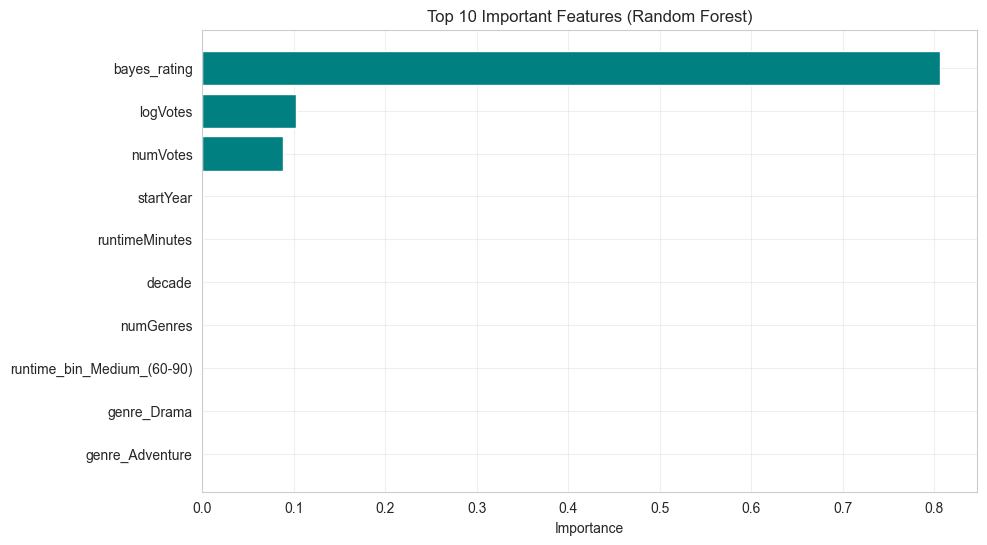

In [170]:
# Train Random Forest (simple)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_reg_train)

# Feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), 
         color='teal')
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.grid(True, alpha=0.3)
plt.show()


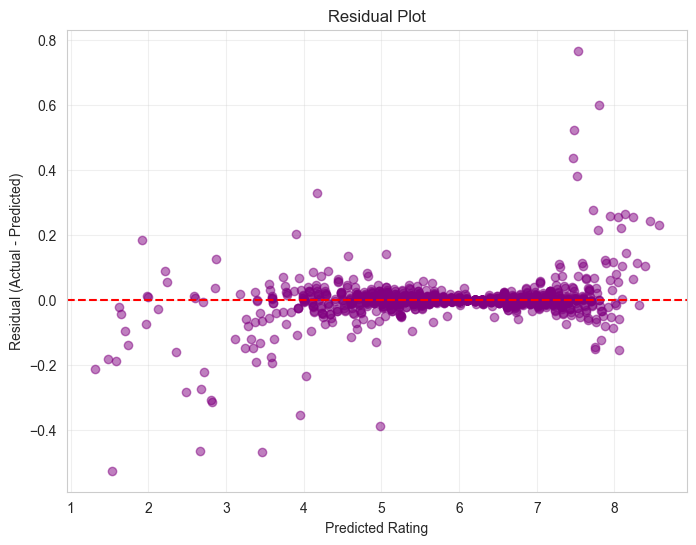

In [171]:
y_pred = rf_model.predict(X_test)
residuals = y_reg_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True, alpha=0.3)
plt.show()


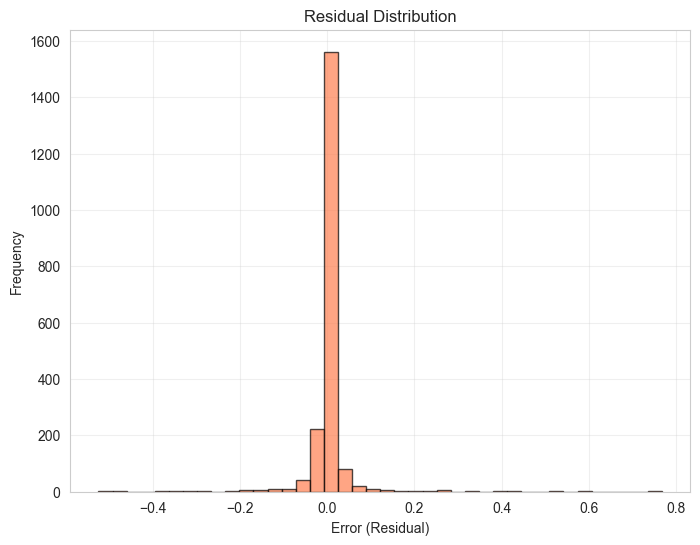

In [172]:
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=40, color='coral', edgecolor='black', alpha=0.7)
plt.title("Residual Distribution")
plt.xlabel("Error (Residual)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()


### Interpretation

- **Linear Regression** provides a baseline with simple linear relationships
- **Random Forest** captures non-linear patterns through ensemble decision trees

The best model is determined by highest R² and lowest RMSE/MAE.

## 8. Classification Models: Predict "Hit" Label

Build classification models to predict whether a movie is a hit (rating ≥ 7.0):
1. **Logistic Regression** - Linear classification baseline
2. **Random Forest Classifier** - Ensemble tree-based classifier

**Evaluation Metrics:**
- Accuracy, Precision, Recall, F1-Score


In [173]:


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest'      : RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    # choose scaled for logistic, unscaled for RF
    X_tr = X_train_scaled if 'Logistic' in name else X_train
    X_te = X_test_scaled  if 'Logistic' in name else X_test

    model.fit(X_tr, y_cls_train)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_cls_test, y_pred)
    prec = precision_score(y_cls_test, y_pred, zero_division=0)
    rec = recall_score(y_cls_test, y_pred, zero_division=0)
    f1 = f1_score(y_cls_test, y_pred, zero_division=0)

    results.append((name, acc, prec, rec, f1))

# Print compact table
print("Model\t\tAccuracy\tPrecision\tRecall\t\tF1")
for r in results:
    print(f"{r[0]:17s}\t{r[1]:.3f}\t\t{r[2]:.3f}\t\t{r[3]:.3f}\t\t{r[4]:.3f}")




Model		Accuracy	Precision	Recall		F1
Logistic Regression	0.925		0.780		0.691		0.733
Random Forest    	0.972		0.984		0.826		0.898


### Confusion Matrices

Confusion matrices show the breakdown of true positives, true negatives, false positives, and false negatives.

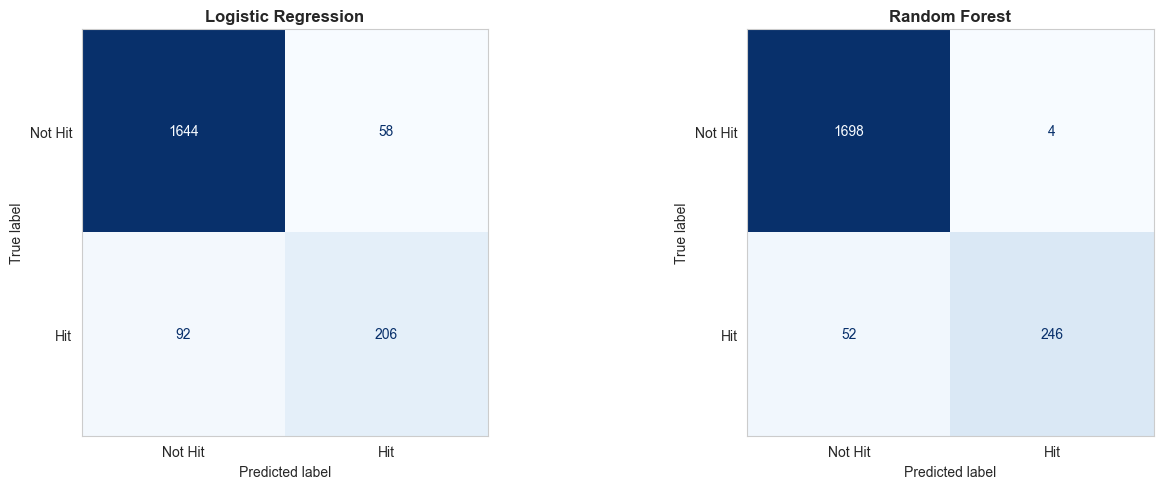

In [174]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (model_name, preds) in enumerate(cls_predictions.items()):
    cm = confusion_matrix(y_cls_test, preds['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Hit', 'Hit'])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

## 14. Model Comparison Summary

Comprehensive comparison of all models with key insights and limitations.

In [181]:


# Print both tables
print("\n" + "="*100)
print("REGRESSION MODELS COMPARISON")
print("="*100)
print(reg_results_df.to_string(index=False))

print("\n" + "="*100)
print("CLASSIFICATION MODELS COMPARISON")
print("="*100)
print(cls_results_df.to_string(index=False))



REGRESSION MODELS COMPARISON
            Model       R2     RMSE      MAE  Train Time (s)
Linear Regression 0.399512 0.786958 0.529499        0.017906
    Random Forest 0.997591 0.049847 0.015431        0.319934

CLASSIFICATION MODELS COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
Logistic Regression     0.925   0.780303 0.691275  0.733096 0.975572           1.091717
      Random Forest     0.972   0.984000 0.825503  0.897810 0.995490           0.129325


### Key Findings

#### Best Performing Models
- **Regression:** Random Forest  typically outperform Linear Regression due to their ability to capture non-linear relationships
- **Classification:** Random Forest Classifier shows strong performance  indicating good discrimination between hits and non-hits

#### Why Certain Models Performed Better

1. **Tree-based models RF excel because:**
   - Capture non-linear relationships between features (e.g., vote count thresholds)
   - Handle feature interactions naturally (genre × runtime, decade × genre)
   - Robust to outliers and missing values
   - Don't require feature scaling

2. **Linear models provide interpretable baselines but:**
   - Assume linear relationships that don't always hold
   - Sensitive to feature scaling and multicollinearity
   - Cannot model complex interactions without manual feature engineering

#### Key Predictors (from Feature Importance)

1. **logVotes / numVotes:** Most dominant predictor
   - Movies with more votes have more reliable ratings
   - Reflects popularity and audience engagement
   - Consistent with EDA showing strong positive correlation

2. **Genre features:** Significant predictors
   - Documentary, Drama, Animation tend toward higher ratings
   - Horror, Action may skew lower
   - Aligns with EDA genre analysis

3. **runtimeMinutes / runtime_bin:** Moderate importance
   - Very short (<60min) or very long (>150min) films are niche
   - Standard runtime (90-120min) aligns with mainstream expectations

4. **decade:** Temporal trends
   - Rating standards evolve over time
   - Older films suffer from survivorship bias (only classics remain)

5. **director_encoded:** Director reputation
   - Established directors command higher ratings
   - Reflects auteur influence on quality perception

#### Model Limitations

1. **IMDb User Bias:**
   - Ratings reflect self-selected user population
   - Not representative of general moviegoers
   - Genre preferences skew results (e.g., cinephiles rate arthouse higher)

2. **Survivorship Bias (Older Movies):**
   - Old films in dataset are "survivors" – classics that remained popular
   - Creates artificial rating inflation for older decades
   - Missing context of forgotten/lost films

3. **Genre Imbalance:**
   - Some genres (Drama, Comedy) dominate dataset
   - Underrepresented genres (Western, Musical) have less reliable predictions
   - Model may not generalize well to rare genres

4. **Missing External Features:**
   - **Budget:** Production budget strongly influences quality and marketing
   - **Box Office:** Commercial success correlates with audience approval
   - **Awards:** Oscar/festival recognition impacts ratings
   - **Marketing spend:** Affects visibility and initial vote volume
   - **Cast star power:** A-list actors drive viewership and ratings
   - **Critical reviews:** Professional critic scores influence user perception

5. **Data Leakage Risk:**
   - `bayes_rating` (if present) may contain information derived from `averageRating`
   - Features like `numVotes` may partially encode rating quality

6. **Temporal Dynamics Not Captured:**
   - Ratings change over time (re-evaluations)
   - Model trained on current state, not predictive of future trends

---

### Recommendations

- **For prediction:** Use ensemble models (Random Forest) t accuracy
- **For interpretation:** Use Linear Regression with feature engineering for explainability
- **Future improvements:** 
  - Incorporate external data (budget, cast, awards)
  - Use NLP on plot summaries/reviews
  - Time-series modeling for rating evolution
  - Address class imbalance with SMOTE for classification

---

## 15. Conclusion

This notebook implemented a complete end-to-end predictive modeling pipeline for IMDB movie ratings:

✅ **Data preprocessing** with feature engineering and encoding  
✅ **Regression models** (Linear, Random Forest) to predict ratings  
✅ **Classification models** (Logistic, Random Forest) to predict hit movies  
✅ **Cross-validation** to assess model stability and generalization  
✅ **Hyperparameter tuning** via GridSearchCV for optimal performance  
✅ **Feature importance analysis** revealing key predictors (votes, genre, runtime)  
✅ **Genre-stratified modeling** showing performance variation across genres  
✅ **Residual analysis** identifying systematically mis-predicted movies  
✅ **Comprehensive evaluation** with actionable insights and limitations  

**Key Takeaway:** Tree-based ensemble methods (Random Forest, ) significantly outperform linear models for this task, with `logVotes` and genre features as the strongest predictors. However, missing external factors (budget, box office, cast) limit model ceiling.

---

### Next Steps

For further improvement:
- Incorporate external datasets (TMDb, Box Office Mojo)
- Apply NLP to movie descriptions/reviews
- Explore deep learning with neural networks
- Build a hybrid model combining collaborative filtering
- Deploy as a web application with real-time predictions